# Khai báo các thư viện cần dùng

In [49]:
# Khai báo các thư viện cần thiết

import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import matplotlib.patches as mpatches
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier


# Khai báo các đường dẫn cần dùng

In [30]:
DATA_TRAIN_READ_PATH = "../data/03_processed/train_features.npz"
DATA_TEST_READ_PATH = "../data/03_processed/test_features.npz"
DATA_VALID_READ_PATH = "../data/03_processed/val_features.npz"

MODEL_OUTPUT_DIR = "../models"

# Thiết lập hàm đọc dữ liệu và trích xuất các đặc trưng tương ứng trong file .npz

In [3]:
def load_data(npz_path,target_features):
    data = np.load(npz_path)
    X = data[target_features]
    y = data['y']
    # Chỉ lấy các label 0,1,2,3,4
    #mask = np.isin(y, [0, 1, 2, 3, 4])
    #X = X[mask]
    #y = y[mask]
    return X, y

In [4]:
# Class name có giá trị là 0 đến 23
class_names = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]

In [5]:
# Đọc dữ liệu huấn luyện, kiểm tra và xác thực ứng với các features sau: X_hist, X_sharp, X_hog, X_lbp, Combined

X_hist_train,y_hist_train = load_data(DATA_TRAIN_READ_PATH, 'X_hist')
X_hist_test,y_hist_test = load_data(DATA_TEST_READ_PATH, 'X_hist')
X_hist_valid,y_hist_valid = load_data(DATA_VALID_READ_PATH, 'X_hist')

X_sharp_train,y_sharp_train = load_data(DATA_TRAIN_READ_PATH, 'X_sharp')
X_sharp_test,y_sharp_test = load_data(DATA_TEST_READ_PATH, 'X_sharp')
X_sharp_valid,y_sharp_valid = load_data(DATA_VALID_READ_PATH, 'X_sharp')

X_hog_train,y_hog_train = load_data(DATA_TRAIN_READ_PATH, 'X_hog')
X_hog_test,y_hog_test = load_data(DATA_TEST_READ_PATH, 'X_hog')
X_hog_valid,y_hog_valid = load_data(DATA_VALID_READ_PATH, 'X_hog')

X_lbp_train,y_lbp_train = load_data(DATA_TRAIN_READ_PATH, 'X_lbp')
X_lbp_test,y_lbp_test = load_data(DATA_TEST_READ_PATH, 'X_lbp')
X_lbp_valid,y_lbp_valid = load_data(DATA_VALID_READ_PATH, 'X_lbp')

X_combined_train,y_combined_train = load_data(DATA_TRAIN_READ_PATH, 'X_combined')
X_combined_test,y_combined_test = load_data(DATA_TEST_READ_PATH, 'X_combined')
X_combined_valid,y_combined_valid = load_data(DATA_VALID_READ_PATH, 'X_combined')

# Thiết lập StandScaler cho tập train

In [6]:
scaler = StandardScaler()

# Thiết lập StandScaler cho tập train X_hist
scaler.fit(X_hist_train)
X_hist_train = scaler.transform(X_hist_train)
X_hist_test = scaler.transform(X_hist_test)
X_hist_valid = scaler.transform(X_hist_valid)

# Thiết lập StandScaler cho tập train X_sharp
scaler.fit(X_sharp_train)
X_sharp_train = scaler.transform(X_sharp_train)
X_sharp_test = scaler.transform(X_sharp_test)
X_sharp_valid = scaler.transform(X_sharp_valid)

# Thiết lập StandScaler cho tập train X_hog
scaler.fit(X_hog_train)
X_hog_train = scaler.transform(X_hog_train)
X_hog_test = scaler.transform(X_hog_test)
X_hog_valid = scaler.transform(X_hog_valid)

# Thiết lập StandScaler cho tập train X_lbp
scaler.fit(X_lbp_train)
X_lbp_train = scaler.transform(X_lbp_train)
X_lbp_test = scaler.transform(X_lbp_test)
X_lbp_valid = scaler.transform(X_lbp_valid)

# Thiết lập StandScaler cho tập train X_combined
scaler.fit(X_combined_train)
X_combined_train = scaler.transform(X_combined_train)
X_combined_test = scaler.transform(X_combined_test)
X_combined_valid = scaler.transform(X_combined_valid)

# Tiến hành PCA cho Hog và Combined

In [7]:
PCA = PCA(n_components=0.95)

# Tiến hành PCA cho Hog
PCA.fit(X_hog_train)
X_hog_train = PCA.transform(X_hog_train)
X_hog_test = PCA.transform(X_hog_test)
X_hog_valid = PCA.transform(X_hog_valid)

# Tiến hành PCA cho Combined
PCA.fit(X_combined_train)
X_combined_train = PCA.transform(X_combined_train)
X_combined_test = PCA.transform(X_combined_test)
X_combined_valid = PCA.transform(X_combined_valid)

In [8]:
# Kiểm tra shape của các tập train ứng với từng feature
print("Shape of X_hist_train:", X_hist_train.shape)
print("Shape of X_sharp_train:", X_sharp_train.shape)
print("Shape of X_hog_train:", X_hog_train.shape)
print("Shape of X_lbp_train:", X_lbp_train.shape)
print("Shape of X_combined_train:", X_combined_train.shape)

Shape of X_hist_train: (8226, 512)
Shape of X_sharp_train: (8226, 256)
Shape of X_hog_train: (8226, 4136)
Shape of X_lbp_train: (8226, 26)
Shape of X_combined_train: (8226, 4216)


# Thiết lập hàm đánh giá để tính các chỉ số đánh giá

In [9]:
def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    return accuracy, precision, recall, f1, cm

In [50]:
def compute_metrics(y_true, y_pred):
    accuracy = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    return accuracy, precision, recall, f1, cm

In [10]:
def print_metrics(accuracy, precision, recall, f1, cm):
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', values_format='d')  # 'd' để in số nguyên
    plt.show()

# Huấn luyện mô hình

## Mô hình SVC

In [11]:
# Khởi tạo các mô hình SVC ứng với các features dùng bộ tham số cơ bản

svc_hist = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, class_weight="balanced")
svc_sharp = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, class_weight="balanced")
svc_hog = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, class_weight="balanced")
svc_lbp = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, class_weight="balanced")
svc_combined = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, class_weight="balanced")

In [12]:
# Huấn luyện mô hình
svc_hist.fit(X_hist_train, y_hist_train)
svc_sharp.fit(X_sharp_train, y_sharp_train)
svc_hog.fit(X_hog_train, y_hog_train)
svc_lbp.fit(X_lbp_train, y_lbp_train)
svc_combined.fit(X_combined_train, y_combined_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,'balanced'
,verbose,False


In [13]:
svc_y_hist_pred = svc_hist.predict(X_hist_test)
svc_y_sharp_pred = svc_sharp.predict(X_sharp_test)
svc_y_hog_pred = svc_hog.predict(X_hog_test)
svc_y_lbp_pred = svc_lbp.predict(X_lbp_test)
svc_y_combined_pred = svc_combined.predict(X_combined_test)

SVC with Histogram Features:
Accuracy: 0.2495
Precision: 0.2294
Recall: 0.2495
F1-score: 0.2246
Confusion Matrix:
[[ 11  21   9   1   5   3   1   7   4   4   4   1   2   5   5   2   4   2
    6   0   2   1   0]
 [  9  32   0   1   5   1   0   2   3  10   1   2   1   1   3   6  10   3
    0   2   3   1   4]
 [  0   0  67   0   1   0   0   1   2   2  10   0   0   0   4   3   0   0
    2   0   4   4   0]
 [  0   0   1  41   0   1  12   0   0   1   8  14   1   6   2   1  15  13
    0   1   0   1  39]
 [ 12   5   1   1  11   7   2   6   7   3   4   1   3   2   4   4   8   4
    6   4   1   2   2]
 [  5  10   1   3   4  10   4   5   3   1   4   1   2   5   4   8   7   7
    3   3   1   1   6]
 [  0   2   8   6   3   1  72   1   0   2   5   2   0   3   1  11   1   7
    0   6   6   1  31]
 [  7   7   2   1   8   0   2  11  16   7   0   2   2   2   4   4   4   4
    9   4   2   1   1]
 [  3   5  12   0   3   1   1   7  26   5   1   0   2   0   8   5   2   0
   12   1   2   3   1]
 [  8   8   7

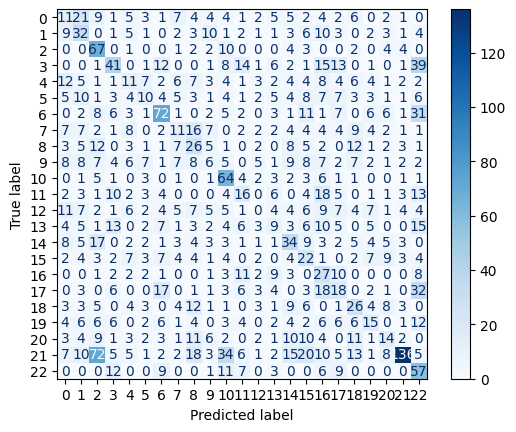

SVC with Sharpness Features:
Accuracy: 0.1573
Precision: 0.1470
Recall: 0.1573
F1-score: 0.1379
Confusion Matrix:
[[15  5  9  3  7  2  1 14  8  3  1  1  1  2 11  0  1  3  5  1  3  4  0]
 [16  8  7  1  4  6  0  9  8  2  2  0  2  3  4  1  4  2 10  0  3  2  6]
 [ 9  4 37  6  0  0  1  5  5  0  8  0  0  0 10  0  1  4  1  0  3  3  3]
 [ 5  6 14 48  0  2  1  0  1  0  3  6  1 12  3  1  7 10  1  1  0  2 33]
 [ 9  4  8  0  8  3  3  9 12  4  1  1  1  2 13  1  1  4  7  3  5  0  1]
 [ 7  1  4  9 11  7  5  4 11  0  0  0  0  4  3  0  4  9  4  4  1  2  8]
 [ 1  2  5 12  2  2 45  1 10  0  2  2  0  9  2  2  2 17  2 19  0  1 31]
 [11  2  4  0 10  5  4 14 12  2  3  0  0  3  7  1  0  2 14  3  2  1  0]
 [10  2 10  0  7  5  2  7 21  1  2  0  1  3  6  1  2  8  6  2  2  2  0]
 [13  6  7  0  7  7  5  8  7  0  6  3  0  1  9  1  1  9 14  1  4  4  0]
 [ 3  4 19  7  1  2  0  4  5  0 19  6  0  3  5  0  4  9  1  0  1  5  2]
 [ 2  2  7 10  1  4  5  2  2  1  9  8  1  9  0  0  6  5  3  1  1  2 15]
 [ 8  3 11  3  6  7  9

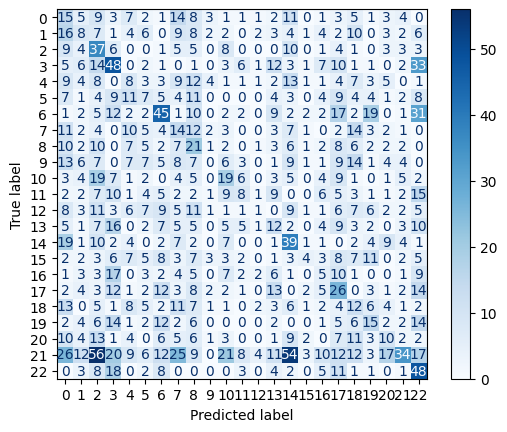

SVC with HOG Features:
Accuracy: 0.2522
Precision: 0.2717
Recall: 0.2522
F1-score: 0.2284
Confusion Matrix:
[[ 5  9 30  7  6  1  1 10  1  5  1  0  2  1  0  0  1  2  1  0 11  6  0]
 [ 1 27 16  1  4  1  0 12  0 17  0  0  0  2  1  0  0  0  1  0 13  4  0]
 [ 4  4 64  0  1  0  1  6  1  2  2  0  0  0  0  0  0  0  0  0  8  7  0]
 [ 1  2  5 60  1  3  8  1  0  0 25  1  0  3  0  0  3 10  0  1  1  8 24]
 [ 1  9 22  3 11  1  0 15  2 11  0  0  2  2  2  0  2  0  3  0  7  4  3]
 [ 0 13 10  6  3  7 11  3  8  3  0  0  3  3  2  0  2  4  4  0  6  9  1]
 [ 0  2  9 19  1  2 80  0  3  5  2  1  0  2  0  1  6  3  0  4  1  3 25]
 [ 2 10 15  1  3  0  2 31  1  9  0  0  1  2  2  0  0  0  1  0 17  3  0]
 [ 6  2 30  4  6  3  3  6 12  9  0  0  2  1  0  1  0  1  3  0  9  2  0]
 [ 3 10 28  3  5  0  3  8  1 19  4  0  1  4  0  0  1  0  4  3  8  8  0]
 [ 0  2  3  4  1  0  0  0  0  0 78  0  1  0  0  0  0  0  0  0  0 11  0]
 [ 1  4  2  9  2  2 11  0  3  3  5  4  0  7  0  2  8  6  0  1  3  7 16]
 [ 3  2 23  4  8  2  3  9  1

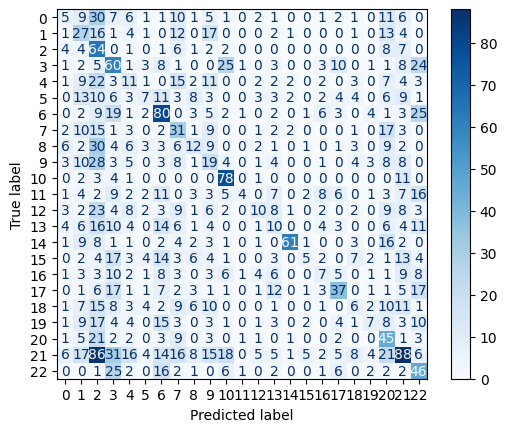

SVC with LBP Features:
Accuracy: 0.2105
Precision: 0.1894
Recall: 0.2105
F1-score: 0.1820
Confusion Matrix:
[[11 10  7  3  7  5  1 18  4  5  3  2  0  3  4  1  5  2  3  0  3  2  1]
 [ 4 28  7  0  1  5  3 17  8  2  1  0  0  1  7  1  3  0  4  0  4  3  1]
 [ 4  2 48  0  1  1  0  8  6  3  6  3  0  0  8  2  0  1  4  0  3  0  0]
 [ 1  4  5 30  2  2  9 11  0  0 30 11  0  2  3  1 13  7  4  1  2  3 16]
 [ 6  8  8  0  4  4  2 28  8  5  3  5  0  3  6  0  4  0  3  0  3  0  0]
 [ 6 11  2  3  4 11  4 12  8  2  1 10  0  0  3  6  3  1  3  3  1  1  3]
 [ 0  2  7  7  5  1 74  5  0  0  0  7  0  6  3  2 14  8  0  8  4  3 13]
 [ 5  6 10  1  5  3  4 39  1  4  0  2  0  1  6  1  3  2  1  0  4  2  0]
 [10  9  8  1  2  5  2  8 28  6  0  2  0  0  4  5  0  0  9  1  0  0  0]
 [ 3  6 11  3  4 11  4 29  5  6  2  4  0  2  5  2  2  4  5  1  2  2  0]
 [ 4  2  6  3  3  5  0 11  0  2 59  1  0  0  1  1  2  0  0  0  0  0  0]
 [ 1  3  1 11  1  5  7  4  1  1  3 20  0  8  0  4 13  4  3  2  0  1  3]
 [ 2 12  3  4  7 10  2 25  9

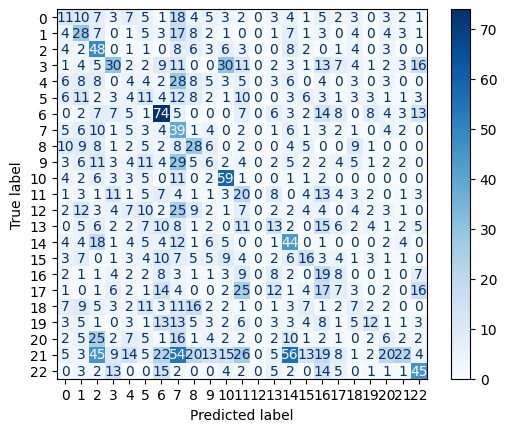

SVC with Combined Features:
Accuracy: 0.2840
Precision: 0.3007
Recall: 0.2840
F1-score: 0.2619
Confusion Matrix:
[[ 14  13  15   4   7   2   1  15   0   9   2   0   2   1   0   0   1   2
    1   0   5   6   0]
 [  3  33   6   1   4   2   0  18   0  17   0   0   2   2   1   0   0   0
    2   0   5   4   0]
 [  1   3  70   0   0   0   1   8   1   4   2   0   0   0   0   0   0   0
    0   0   4   6   0]
 [  0   1   6  68   0   2   8   0   0   0  19   1   0   4   0   0   5   8
    0   2   1   4  28]
 [  2  12   9   3  13   0   1  23   1  11   0   0   7   1   0   0   3   1
    2   1   6   4   0]
 [  1  14   7   4   5   7  10   6   8   5   0   1   2   2   1   0   3   6
    3   1   4   6   2]
 [  0   2  11  14   3   3  82   0   1   2   3   0   0   4   0   1   4   4
    1   4   1   2  27]
 [  4  10   6   1   6   0   3  40   0   9   0   0   1   0   2   0   0   0
    2   1  11   4   0]
 [  6   5  20   3  10   2   2   9  14   9   0   0   3   0   0   1   0   1
    3   0   9   3   0]
 [  7  14  12 

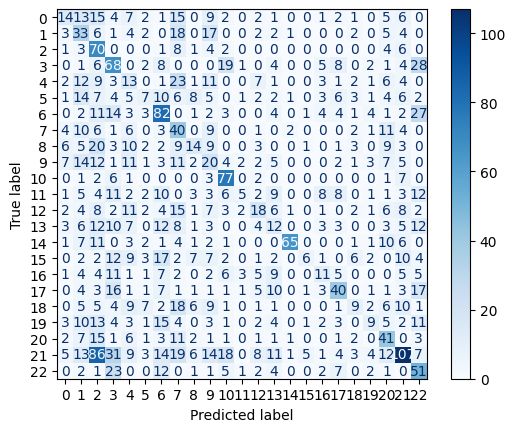

In [51]:
# Tính toán và in các chỉ số đánh giá cho từng mô hình
svc_hist_metrics = compute_metrics(y_hist_test, svc_y_hist_pred)
print("SVC with Histogram Features:")
print_metrics(*svc_hist_metrics)

svc_sharp_metrics = compute_metrics(y_sharp_test, svc_y_sharp_pred)
print("SVC with Sharpness Features:")
print_metrics(*svc_sharp_metrics)

svc_hog_metrics = compute_metrics(y_hog_test, svc_y_hog_pred)
print("SVC with HOG Features:")
print_metrics(*svc_hog_metrics)

svc_lbp_metrics = compute_metrics(y_lbp_test, svc_y_lbp_pred)
print("SVC with LBP Features:")
print_metrics(*svc_lbp_metrics)

svc_combined_metrics = compute_metrics(y_combined_test, svc_y_combined_pred)
print("SVC with Combined Features:")
print_metrics(*svc_combined_metrics)

## Mô hình Logistic Regression

In [15]:
# Thiết lập các mô hình Logistic Regression ứng với các features dùng bộ tham số cơ bản 
logreg_hist = LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced")
logreg_sharp = LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced")
logreg_hog = LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced")
logreg_lbp = LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced")
logreg_combined = LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced")

In [16]:
# Huấn luyện mô hình Logistic Regression
logreg_hist.fit(X_hist_train, y_hist_train)
logreg_sharp.fit(X_sharp_train, y_sharp_train)
logreg_hog.fit(X_hog_train, y_hog_train)
logreg_lbp.fit(X_lbp_train, y_lbp_train)
logreg_combined.fit(X_combined_train, y_combined_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [17]:
lr_y_hist_pred = logreg_hist.predict(X_hist_test)
lr_y_sharp_pred = logreg_sharp.predict(X_sharp_test)
lr_y_hog_pred = logreg_hog.predict(X_hog_test)
lr_y_lbp_pred = logreg_lbp.predict(X_lbp_test)
lr_y_combined_pred = logreg_combined.predict(X_combined_test)

Logistic Regression with Histogram Features:
Accuracy: 0.2186
Precision: 0.2071
Recall: 0.2186
F1-score: 0.2046
Confusion Matrix:
[[ 11  12   3   0   9   4   1  10   4   5   1   2   8   6   4   3   3   2
    4   3   2   2   1]
 [ 11  15   0   1   3   4   0   6   6  10   1   2   5   4   4   2   7   9
    2   2   2   3   1]
 [  0   1  59   1   0   2   3   2   5   1   3   1   1   1   3   1   0   1
    2   1   3   7   2]
 [  0   1   0  50   0   0   8   0   0   1   5  17   2  11   0   1   6   7
    0   3   1   3  41]
 [  9   5   2   1   6   4   2   8   5   2   6   2   8   3   2   3   5   6
    6   7   4   2   2]
 [  4   6   0   2   3   8   5   7   5   6   3   4   4   9   5   3   4   7
    2   4   2   0   5]
 [  1   3   3   7   3   2  77   1   0   2   2   3   0   5   2   7   2   9
    5   4   1   2  28]
 [  7   5   3   1   3   1   2  10  10  15   0   3   6   3   4   1   6   1
    8   5   5   1   0]
 [ 10   3   8   0   5   1   2   5  12   8   0   2   5   3   6   3   4   2
    8   5   4   4   

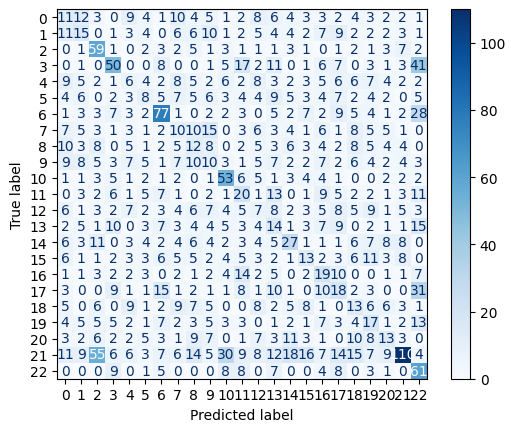

Logistic Regression with Sharpness Features:
Accuracy: 0.1039
Precision: 0.0966
Recall: 0.1039
F1-score: 0.0943
Confusion Matrix:
[[ 8 13  6  4  7  4  0  4  7  5  0  1  3  4 11  1  4  2  7  1  3  4  1]
 [10  9  5  3  9  7  0  7  4  8  1  0  4  7  3  1  1  4 10  0  3  1  3]
 [ 4  7 18  7  0  3  2  4  4  3  5  5  1  2 11  2  5  1  1  2  4  4  5]
 [ 1  6  5 29  2  5  6  2  2  2  9 16  2 12  2  2  6 12  0  3  1  3 29]
 [ 8  7  6  2  6  5  4  5  8  2  1  1  5  1  9  0  0  5  6  7  8  3  1]
 [ 2  5  2  9  3  3  1  5  7  3  2  2  2  4  5  7  3  9  3  7  2  0 12]
 [ 2  4  4 10  3  4 33  1  3  3  7  4  2 10  3  4 11 13  4 15  3  3 23]
 [ 8  5  3  2  7  3  1  8 13  7  4  0  4  2  9  3  1  4  6  2  5  2  1]
 [ 6  5  2  3  8  4  4  6 12  7  0  2  3  4  8  1  2  3  8  1  6  2  3]
 [ 6  7  4  3  4  6  4 11  8  2  4  1  5  3 10  1  6  3 10  1  7  6  1]
 [ 5  4 15  5  3  2  1  2  2  5  4  8  2  6 13  2  1  3  4  3  3  5  2]
 [ 1  1  6 11  0  6  8  1  3  3  6  7  3  6  1  1  5  5  4  3  0  1 14]
 [ 7  

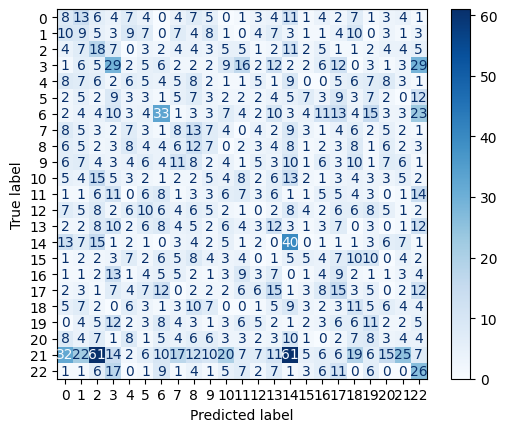

Logistic Regression with HOG Features:
Accuracy: 0.1898
Precision: 0.1882
Recall: 0.1898
F1-score: 0.1873
Confusion Matrix:
[[ 13   9   7   1   6   7   1   5   2   8   0   0   4   1   1   1   3   0
    2   0   5  24   0]
 [  7   9   1   2  10   4   1  12   5  10   0   0   2   3   3   0   0   1
    3   6   5  16   0]
 [  7   5  24   0   8   1   2   5   5   5   1   0   4   2   0   3   1   2
    5   4   4  11   1]
 [  2   1   1  63   1   2   9   0   2   3  13   9   0   4   2   2   3  13
    1   0   1  13  12]
 [  7   2   7   2   7   7   2   9   4   8   1   3   7   1   4   4   3   3
    5   3   4   7   0]
 [  4   5   6   3   2   4   5   3  10   3   0   6   4   5   5   2   3   8
    2   1   3  11   3]
 [  2   0   2   9   1   4  53   4   1   4   2   2   3  11   1   4   7   8
    1  11   1  12  26]
 [  5  10   3   1   3   3   0  14   2   8   0   0   4   0   7   2   0   1
    7   1  12  15   2]
 [  6   1  16   1   9   2   0   7   9   5   0   2   5   1   0   2   2   3
    7   0   8  12   2]
 [ 

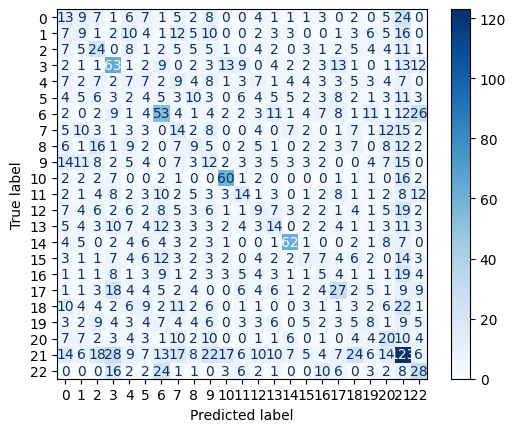

Logistic Regression with LBP Features:
Accuracy: 0.1957
Precision: 0.1790
Recall: 0.1957
F1-score: 0.1720
Confusion Matrix:
[[11  8 10  3  6  3  1  2  4  2  5  4  1  5 11  2  2  1  9  0  5  5  0]
 [ 3 23  9  1  0  2  1  6  7  4  5  0  0  1  8  0  3  0 16  1  4  4  2]
 [ 3  4 44  2  2  2  0  5  5  1  5  0  0  1 19  2  0  0  3  0  1  1  0]
 [ 0  4  8 28  1  1  4  0  1  0 35  9  0  6  7  1 13  9  1  2  1  7 19]
 [ 6  8 12  3  3  3  0 12  4  5  5  5  0  4  9  1  3  0  6  1  6  3  1]
 [ 2 10  5  2  9  7  6  0  5  1  3  9  1  1  4  6  4  4  9  2  5  2  1]
 [ 0  1  6  6  1  1 60  4  3  3  2  6  0  9  6  3 10  7  0 13  2  3 23]
 [ 3  9 17  2  4  1  5  7  1  4  2  3  0  1 26  1  0  0  2  0  7  5  0]
 [ 3  8 14  0  1  6  1  1 28  4  2  1  0  0  6  4  0  0 19  0  2  0  0]
 [ 4  9 19  3  5  4  5  5  3  4  4  1  4  2 11  1  4  3  8  1  5  6  2]
 [ 4  2  5  7  2  4  0  3  0  2 57  2  0  0  7  1  3  0  0  0  1  0  0]
 [ 0  5  1 10  1  5  4  0  1  1  5 13  5  5  3  7 10  9  0  2  0  0  9]
 [ 3 15 10  

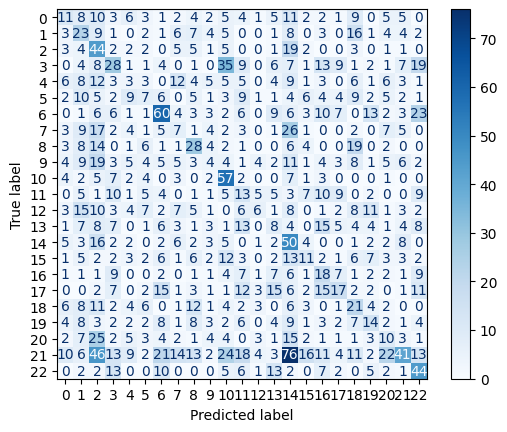

Logistic Regression with Combined Features:
Accuracy: 0.2627
Precision: 0.2599
Recall: 0.2627
F1-score: 0.2592
Confusion Matrix:
[[ 14  13   2   1   5   8   2   7   5  10   1   0   7   1   2   1   4   0
    5   0   3   9   0]
 [  6  19   0   2  10   6   2   7   3   9   0   0   4   2   3   1   2   2
    3   4   5  10   0]
 [  2   1  41   0   5   1   0   2   4   3   2   0   2   1   0   0   1   2
    2   2   3  26   0]
 [  1   0   1  83   0   2   4   0   0   1  12  11   0   2   1   1   4  10
    0   0   0   8  16]
 [  6  10   1   0  11   8   3  10   6   5   1   1  11   1   2   4   3   3
    4   1   5   3   1]
 [  4   7   4   7   4   7   7   3   7   3   1   4   3   7   4   2   4   8
    4   2   2   2   2]
 [  2   2   2   6   1   3  76   2   2   4   2   1   3   5   0   5   2   6
    1  10   2  11  21]
 [  7   9   5   1   4   3   0  19   4   8   1   0   8   1   6   1   0   0
    6   1   9   7   0]
 [  9   2  11   0   6   4   0   8  16   7   1   0   4   1   2   2   0   3
   10   0   8   5   1

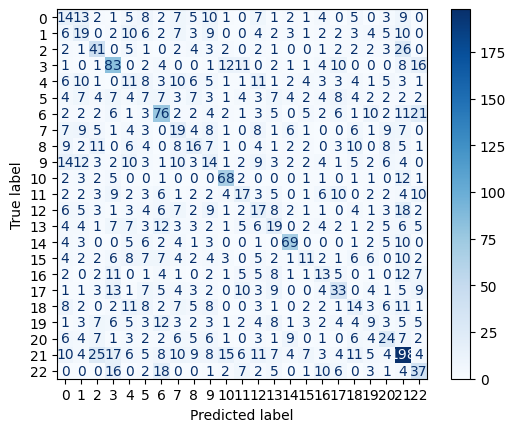

In [52]:
# Tính toán và in các chỉ số đánh giá cho từng mô hình
lr_hist_metrics = compute_metrics(y_hist_test, lr_y_hist_pred)
print("Logistic Regression with Histogram Features:")
print_metrics(*lr_hist_metrics)

lr_sharp_metrics = compute_metrics(y_sharp_test, lr_y_sharp_pred)
print("Logistic Regression with Sharpness Features:")
print_metrics(*lr_sharp_metrics)

lr_hog_metrics = compute_metrics(y_hog_test, lr_y_hog_pred)
print("Logistic Regression with HOG Features:")
print_metrics(*lr_hog_metrics)

lr_lbp_metrics = compute_metrics(y_lbp_test, lr_y_lbp_pred)
print("Logistic Regression with LBP Features:")
print_metrics(*lr_lbp_metrics)

lr_combined_metrics = compute_metrics(y_combined_test, lr_y_combined_pred)
print("Logistic Regression with Combined Features:")
print_metrics(*lr_combined_metrics)

## Mô hình KNN

In [19]:
# Thiết lập các mô hình KNN ứng với các features dùng bộ tham số cơ bản
knn_hist = KNeighborsClassifier(n_neighbors=24)
knn_sharp = KNeighborsClassifier(n_neighbors=24)
knn_hog = KNeighborsClassifier(n_neighbors=24)
knn_lbp = KNeighborsClassifier(n_neighbors=24)
knn_combined = KNeighborsClassifier(n_neighbors=24)

In [20]:
# Huấn luyện mô hình
knn_hist.fit(X_hist_train, y_hist_train)
knn_sharp.fit(X_sharp_train, y_sharp_train)
knn_hog.fit(X_hog_train, y_hog_train)
knn_lbp.fit(X_lbp_train, y_lbp_train)
knn_combined.fit(X_combined_train, y_combined_train)

,n_neighbors,24
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [21]:
knn_y_hist_pred = knn_hist.predict(X_hist_test)
knn_y_sharp_pred = knn_sharp.predict(X_sharp_test)
knn_y_hog_pred = knn_hog.predict(X_hog_test)
knn_y_lbp_pred = knn_lbp.predict(X_lbp_test)
knn_y_combined_pred = knn_combined.predict(X_combined_test)

KNN with Histogram Features:
Accuracy: 0.2025
Precision: 0.1974
Recall: 0.2025
F1-score: 0.1882
Confusion Matrix:
[[ 19  16   5   3   3   2   3   7   3   4   3   2   1   3   3   0   1   2
    4   1   0  12   3]
 [ 17  21   0   3   2   2   3   6   2   6   2   2   3   0   2   0   5   5
    1   1   2   5  10]
 [  0   0  51   0   1   0   0   3   1   3   7   0   0   0   0   0   0   0
    1   0   1  32   0]
 [  0   0   1  62   0   0  15   0   0   2  10   8   1   5   1   0   2  11
    0   2   0   5  32]
 [ 15   6   1   5   8   2   4   8   6  10   1   3   3   0   1   0   2   4
    4   2   1  10   4]
 [ 11   6   1   7   7   2  13   6   1   2   2   4   1   1   1   0   4   6
    3   3   2   9   6]
 [  0   1   6  13   2   2  87   2   2   3   3   3   2   2   1   0   0  13
    1   4   0   8  14]
 [ 15   4   3   3   8   2   7  14   9   6   0   2   2   1   4   2   0   2
    4   3   1   7   1]
 [ 11   2   6   1   3   0   5  15  16   6   0   0   4   0   2   0   1   2
    4   0   0  22   0]
 [ 12  11   5

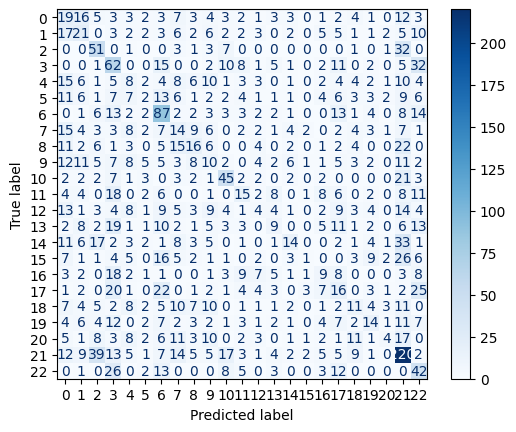

KNN with Sharpness Features:
Accuracy: 0.1307
Precision: 0.1398
Recall: 0.1307
F1-score: 0.1251
Confusion Matrix:
[[  9   8   4   3   9   0   2  11   4   7   3   0   1   0   5   0   0   1
    2   1   2  28   0]
 [ 13   9   7   7   3   4   0   9   2   4   0   0   0   2   1   0   0   0
    4   0   5  29   1]
 [  3   1  25   7   1   1   1   2   2   2   8   0   1   1   3   0   1   1
    3   1   0  36   0]
 [  4   4  21  51   2   2   5   0   2   4   7   1   1   3   2   0   3   2
    2   2   0  34   5]
 [ 12   7   6   0   9   1   5  11   4   6   2   0   1   0   6   1   0   0
    3   2   4  18   2]
 [  7   9   7   9   7   8   4   3   5   9   2   1   0   0   1   0   0   2
    4   3   1  15   1]
 [  3   5   8  12   7   4  55   1   6   1   5   3   4   2   1   1   1  11
    3   8   1  22   5]
 [ 20   6   3   2   4   5   4  13   6   4   2   0   3   1   3   0   0   0
    3   1   3  17   0]
 [  8   4   4   0   9   1   4  12  11  15   0   0   1   0   4   0   0   0
    9   0   0  18   0]
 [ 11   9   3

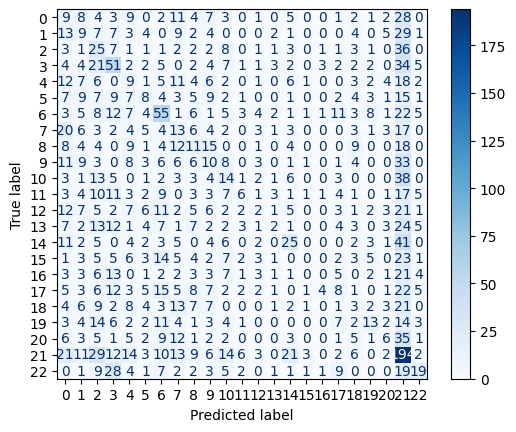

KNN with HOG Features:
Accuracy: 0.1155
Precision: 0.1417
Recall: 0.1155
F1-score: 0.0967
Confusion Matrix:
[[  0   0  76   0   0   0   4   0   0   0   0   0   0   0   0   0   0   0
    0   0   2  18   0]
 [  0   0  87   0   0   0   5   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   8   0]
 [  0   0  88   0   0   0   7   0   0   0   0   0   0   0   0   0   0   0
    0   0   2   3   0]
 [  0   0  41  31   0   0   9   0   0   0   3   0   0   1   1   0   0   1
    0   3   0  57  10]
 [  0   0  87   0   0   0   5   0   0   0   0   0   0   0   0   0   0   0
    0   0   1   7   0]
 [  0   0  74   0   0   0   8   0   0   0   0   0   0   1   1   0   0   0
    0   0   1  12   1]
 [  0   0  71   5   0   0  48   0   0   0   0   0   0   0   1   0   0   1
    0   4   2  26  11]
 [  0   0  91   0   0   0   3   0   0   0   0   0   0   0   1   0   0   0
    0   0   1   4   0]
 [  0   0  91   0   0   0   4   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   4   1]
 [  0   0  85   3  

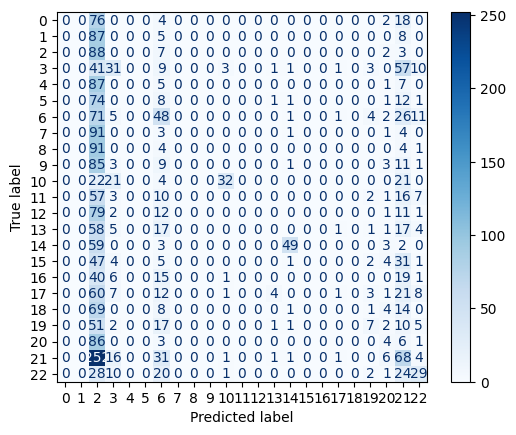

KNN with LBP Features:
Accuracy: 0.1583
Precision: 0.1727
Recall: 0.1583
F1-score: 0.1548
Confusion Matrix:
[[ 11  12   6   2   7   3   3   7   4   3   0   2   5   1   1   1   0   4
    2   0   1  25   0]
 [ 11  21   5   0   9   3   2   6   5   3   1   0   4   0   0   1   1   1
    3   1   1  21   1]
 [  5   3  29   3   0   0   0  10   6   2   3   1   1   1   0   1   0   0
    0   1   2  32   0]
 [  1   6   3  37   2   2  11   2   1   0  17   6   1   3   2   0   7  12
    2   1   2  28  11]
 [  5   5   5   1  10   3   2  16   4   4   0   3   6   4   1   0   2   0
    0   0   2  27   0]
 [  8  10   1   5   1   6   5   5   7   6   0   6   3   2   0   1   2   4
    2   1   1  19   3]
 [  0   3   1  12   2   0  79   1   1   2   0   5   2   3   2   2   2   5
    0   4   1  30  12]
 [  6   6   3   0   7   4   4  17   0   6   1   4   3   0   2   0   0   1
    2   0   4  30   0]
 [  7   8   5   1   4  11   1   7  20   3   0   2   4   0   2   2   0   2
    4   0   0  17   0]
 [  8   3   8   1  

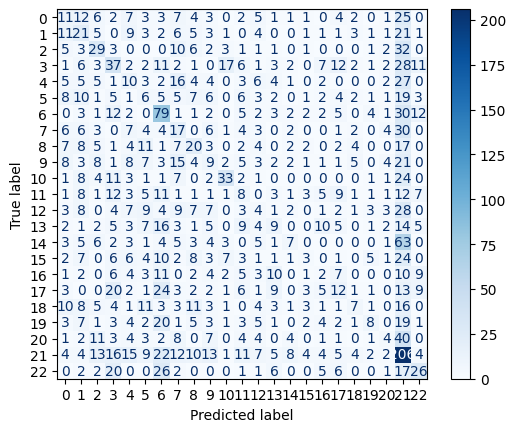

KNN with Combined Features:
Accuracy: 0.1169
Precision: 0.1528
Recall: 0.1169
F1-score: 0.0984
Confusion Matrix:
[[  0   0  81   0   0   0   4   0   0   0   0   0   0   0   0   0   0   0
    0   1   0  14   0]
 [  0   0  89   0   0   0   4   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   7   0]
 [  0   0  91   0   0   0   3   0   0   0   0   0   0   0   0   0   0   0
    0   0   1   5   0]
 [  0   0  47  33   0   0   8   0   0   0   3   0   0   2   0   0   0   2
    0   3   0  47  12]
 [  0   0  84   0   0   0   6   0   0   0   0   0   0   0   0   0   0   0
    0   0   2   8   0]
 [  0   0  75   0   0   0   7   0   0   0   0   0   0   1   1   0   0   0
    0   0   2  11   1]
 [  0   0  76   8   0   0  48   0   0   0   0   0   0   0   1   0   0   1
    0   3   0  19  13]
 [  0   0  91   0   0   0   4   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   5   0]
 [  0   0  91   0   0   0   4   0   0   0   0   0   0   0   0   0   0   0
    0   0   1   3   1]
 [  0   0  89 

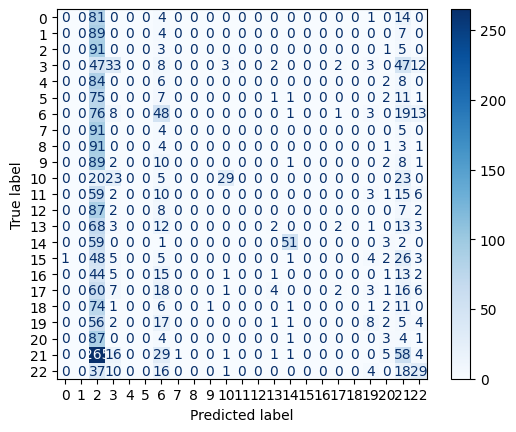

In [53]:
# Tính toán và in các chỉ số đánh giá cho từng mô hình
knn_hist_metrics = compute_metrics(y_hist_test, knn_y_hist_pred)
print("KNN with Histogram Features:")
print_metrics(*knn_hist_metrics)

knn_sharp_metrics = compute_metrics(y_sharp_test, knn_y_sharp_pred)
print("KNN with Sharpness Features:")
print_metrics(*knn_sharp_metrics)

knn_hog_metrics = compute_metrics(y_hog_test, knn_y_hog_pred)
print("KNN with HOG Features:")
print_metrics(*knn_hog_metrics)

knn_lbp_metrics = compute_metrics(y_lbp_test, knn_y_lbp_pred)
print("KNN with LBP Features:")
print_metrics(*knn_lbp_metrics)

knn_combined_metrics = compute_metrics(y_combined_test, knn_y_combined_pred)
print("KNN with Combined Features:")
print_metrics(*knn_combined_metrics)

## Mô hình XGBoost

In [23]:
classes = np.unique(y_combined_train)
class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_combined_train)

class_weights_dict = dict(zip(classes, class_weights))

sample_weights_hist = np.array([class_weights_dict[label] for label in y_hist_train])
sample_weights_sharp = np.array([class_weights_dict[label] for label in y_sharp_train])
sample_weights_hog = np.array([class_weights_dict[label] for label in y_hog_train])
sample_weights_lbp = np.array([class_weights_dict[label] for label in y_lbp_train])
sample_weights_combined = np.array([class_weights_dict[label] for label in y_combined_train])

In [24]:
# Thiết lập mô hình XGBoost ứng với các features dùng bộ tham số cơ bản
xgb_hist = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_sharp = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_hog = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_lbp = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_combined = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

In [25]:
# Huấn luyện mô hình
xgb_hist.fit(X_hist_train, y_hist_train, sample_weight=sample_weights_hist)
xgb_sharp.fit(X_sharp_train, y_sharp_train, sample_weight=sample_weights_sharp)
xgb_hog.fit(X_hog_train, y_hog_train, sample_weight=sample_weights_hog)
xgb_lbp.fit(X_lbp_train, y_lbp_train, sample_weight=sample_weights_lbp)
xgb_combined.fit(X_combined_train, y_combined_train, sample_weight=sample_weights_combined)

e:\GitHub\CS231_CV_Project_Classification_Sea_Animals\cv_env\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:36:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
e:\GitHub\CS231_CV_Project_Classification_Sea_Animals\cv_env\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:38:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
e:\GitHub\CS231_CV_Project_Classification_Sea_Animals\cv_env\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:40:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
e:\GitHub\CS231_CV_Project_Classification_Sea_Animals\cv_env\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [26]:
xgb_y_hist_pred = xgb_hist.predict(X_hist_test)
xgb_y_sharp_pred = xgb_sharp.predict(X_sharp_test)
xgb_y_hog_pred = xgb_hog.predict(X_hog_test)
xgb_y_lbp_pred = xgb_lbp.predict(X_lbp_test)
xgb_y_combined_pred = xgb_combined.predict(X_combined_test)

XGBoost with Histogram Features:
Accuracy: 0.3117
Precision: 0.3149
Recall: 0.3117
F1-score: 0.3104
Confusion Matrix:
[[ 16  11   3   1  13   6   0   2   4   7   1   3   9   3   0   4   0   9
    4   0   0   4   0]
 [ 12  25   1   1   6   4   0   5   1   5   2   1  10   6   6   3   1   2
    1   1   3   3   1]
 [  0   0  57   0   0   1   0   2   1   1   0   0   1   0   3   1   0   0
    3   0   9  21   0]
 [  0   0   0  85   0   3   8   0   0   0   1   5   1   4   0   1   6   8
    0   1   1   5  28]
 [  8   7   0   1  10   4   0   6   1   4   2   5  10   3   3   2   2   8
    8   4   3   9   0]
 [  6  11   1   2   8   7   4   2   3   6   2   1   5   6   3   3   1   8
    1   5   5   7   1]
 [  0   1   1   8   0   0 109   0   2   1   3   3   0   3   3   3   1   5
    0   5   3   9   9]
 [  7   5   1   1   4   2   1  20   6  13   0   2   9   2   4   0   0   1
    9   2   6   5   0]
 [  8   2   5   0   6   0   0   2  20   9   0   1   4   1   9   6   0   1
   14   0   2  10   0]
 [  8   7

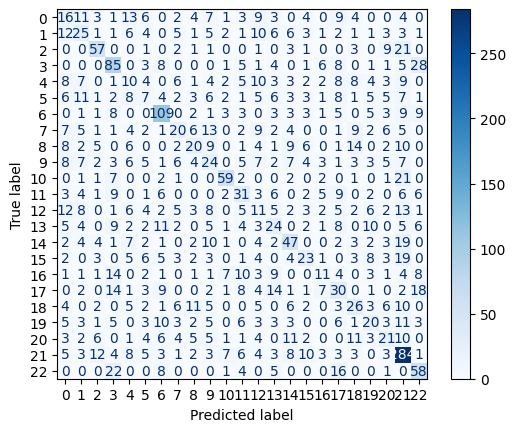

XGBoost with Sharpness Features:
Accuracy: 0.1613
Precision: 0.1626
Recall: 0.1613
F1-score: 0.1574
Confusion Matrix:
[[ 11  10   2   1   7   4   2   5   2   8   0   1   5   3   5   0   0   2
    5   0   6  21   0]
 [  6  12   1   5   4   4   2   3   5   7   3   1   3   1   2   1   3   0
    2   1   6  28   0]
 [  3   2  19   5   1   0   2   3   2   3   7   3   0   1   2   0   1   0
    1   0   2  41   2]
 [  1   1   4  53   0   4   4   1   1   4   0   6   0   6   0   2   7  12
    1   2   0  29  19]
 [  5   7   2   5   6   4   6   5  12   4   2   0   2   2   5   3   1   2
    5   2   2  17   1]
 [  2   4   0  15   2   4  10   3   3   5   2   2   3   5   2   2   1   9
    3   1   5  14   1]
 [  1   2   2  21   0   2  71   2   2   0   2   2   1   1   3   3   2  16
    4   9   2  18   3]
 [ 10   5   0   2   7   1   2   8   4   7   4   0  14   3   4   2   0   1
    9   2   1  14   0]
 [  8   2   7   1   5   2   7   7  12   7   0   1   3   0   4   2   1   5
    6   2   2  16   0]
 [ 11   5

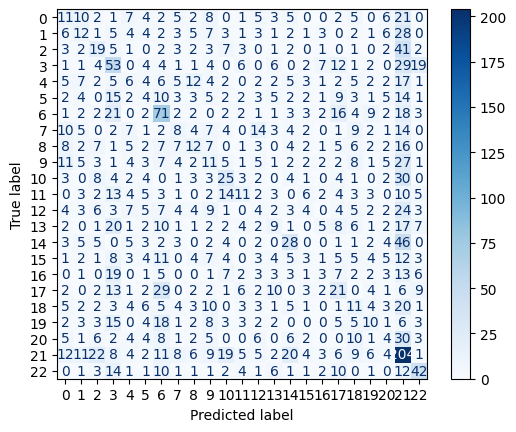

XGBoost with HOG Features:
Accuracy: 0.1783
Precision: 0.2040
Recall: 0.1783
F1-score: 0.1681
Confusion Matrix:
[[  2   5   9   4   1   1   0   5   0   5   1   0   3   2   1   2   0   1
    2   0   3  51   2]
 [  4   4  13   2   4   0   0  10   2   4   0   0   3   3   3   0   1   1
    0   0  10  36   0]
 [  1   4  17   0   2   0   1   3   0   7   2   0   1   2   1   0   0   0
    0   0   4  55   0]
 [  0   1   1  59   0   0   7   0   0   0  14   2   1   1   0   1   0   5
    0   0   2  40  23]
 [  2   2   9   3   8   1   1   1   1   7   0   0   3   0   1   1   0   1
    2   0   7  49   1]
 [  0   5   4   5   2   0   9   2   1   1   0   1   2   1   2   2   1   5
    2   0   4  48   1]
 [  0   0   3  13   2   0  66   1   0   2   3   3   1   0   0   0   3   3
    0   6   0  39  24]
 [  5   1   5   1   3   0   0   9   0   8   0   0   2   0   3   1   0   0
    1   1  15  45   0]
 [  1   3  15   2   0   1   3   2   3   5   0   0   2   0   0   0   1   0
    1   1  10  49   1]
 [  4   2   8  

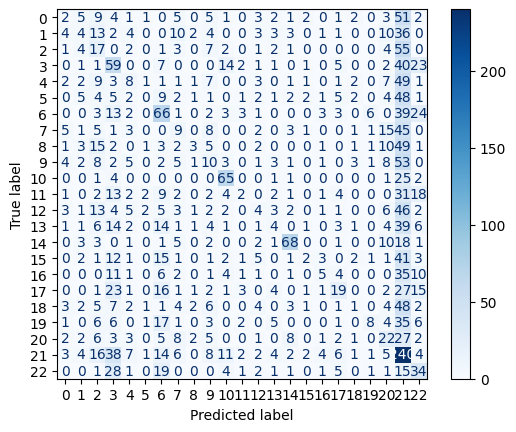

XGBoost with LBP Features:
Accuracy: 0.1854
Precision: 0.1858
Recall: 0.1854
F1-score: 0.1838
Confusion Matrix:
[[  8   5   7   3   3   7   3   8   3   7   2   1   5   1   3   2   3   1
    4   1   0  21   2]
 [  8  16   6   2   4   6   1   8   5   6   0   0   7   4   4   2   1   1
    8   0   1   9   1]
 [  1   2  28   2   1   1   0   3   4   9   3   1   2   0   7   1   0   0
    4   0   7  24   0]
 [  1   0   1  47   3   3   8   0   1   0  16   9   1   6   1   3  12  11
    1   1   1  11  20]
 [  7   3   5   1   9   2   1  11   2   9   1   4   8   4   4   5   1   3
    3   1   4  12   0]
 [  5  10   0   2   4   9   3   8   5   2   1   1   2   2   0   6   2   9
    5   3   2  14   3]
 [  0   1   1  13   4   0  76   1   1   1   1   4   3   2   4   3   2  15
    0  11   1  17   8]
 [  7   6   4   1   4   4   3  15   1   8   0   0   4   2   5   0   1   1
    4   3   5  22   0]
 [  7   1   5   0   9  10   0   4  16  11   1   1   4   1   2   5   0   1
   11   2   3   6   0]
 [  4   6   5  

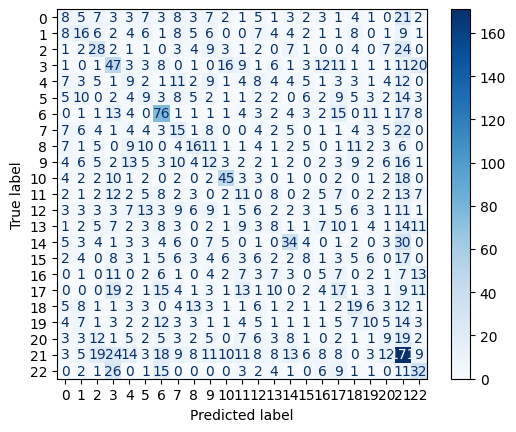

XGBoost with Combined Features:
Accuracy: 0.2055
Precision: 0.2192
Recall: 0.2055
F1-score: 0.1916
Confusion Matrix:
[[  6   5  10   4   1   0   0  11   2   7   1   0   3   0   0   0   0   2
    4   1   4  37   2]
 [  8  15   4   2   5   0   0  13   1  13   1   0   2   2   2   0   0   1
    0   1   7  23   0]
 [  4   2  34   0   2   0   1   0   0   4   3   0   4   0   3   0   0   0
    0   0   7  36   0]
 [  0   0   2  63   0   1  10   1   0   1  15   1   0   6   0   0   1   4
    0   1   0  31  20]
 [  3   4   4   3  10   0   2  11   1   9   1   0   0   3   2   0   1   3
    2   0   5  36   0]
 [  0   4   1   4   0   1   9   2   3   5   0   1   5   4   2   2   2   3
    1   0   4  40   5]
 [  0   0   2  14   2   0  79   1   1   0   4   4   0   2   0   0   1   4
    1   6   0  31  17]
 [  5   2   6   2   6   0   1  21   0   9   0   0   5   0   2   0   1   1
    1   0  11  27   0]
 [  1   3   7   1   9   1   2   4   3   8   0   0   2   0   0   2   0   1
    3   2   9  42   0]
 [  4   8 

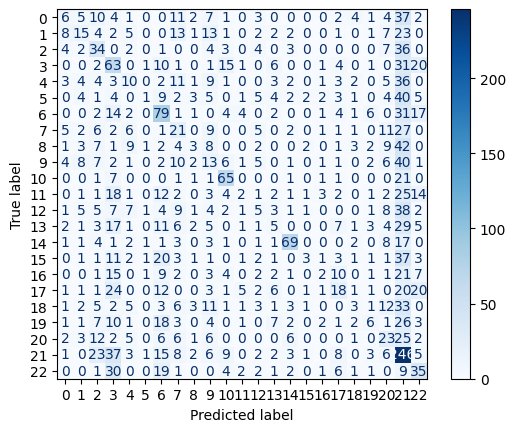

In [54]:
# Tính toán và in các chỉ số đánh giá cho từng mô hình
xgb_hist_metrics = compute_metrics(y_hist_test, xgb_y_hist_pred)
print("XGBoost with Histogram Features:")
print_metrics(*xgb_hist_metrics)

xgb_sharp_metrics = compute_metrics(y_sharp_test, xgb_y_sharp_pred)
print("XGBoost with Sharpness Features:")
print_metrics(*xgb_sharp_metrics)

xgb_hog_metrics = compute_metrics(y_hog_test, xgb_y_hog_pred)
print("XGBoost with HOG Features:")
print_metrics(*xgb_hog_metrics)

xgb_lbp_metrics = compute_metrics(y_lbp_test, xgb_y_lbp_pred)
print("XGBoost with LBP Features:")
print_metrics(*xgb_lbp_metrics)

xgb_combined_metrics = compute_metrics(y_combined_test, xgb_y_combined_pred)
print("XGBoost with Combined Features:")
print_metrics(*xgb_combined_metrics)

## Mô hình RandomForest

In [35]:
rf_hist = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced")
rf_sharp = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced")
rf_hog = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced")
rf_lbp = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced")
rf_combined = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced")

In [36]:
rf_hist.fit(X_hist_train,y_hist_train)
rf_sharp.fit(X_sharp_train,y_sharp_train)
rf_hog.fit(X_hog_train,y_hog_train)
rf_lbp.fit(X_lbp_train,y_lbp_train)
rf_combined.fit(X_combined_train,y_combined_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [37]:
rf_y_hist_pred = rf_hist.predict(X_hist_test)
rf_y_sharp_pred = rf_sharp.predict(X_sharp_test)
rf_y_hog_pred = rf_hog.predict(X_hog_test)
rf_y_lbp_pred = rf_lbp.predict(X_lbp_test)
rf_y_combined_pred = rf_combined.predict(X_combined_test)

RandomForest with Histogram Features:
Accuracy: 0.2982
Precision: 0.3086
Recall: 0.2982
F1-score: 0.2925
Confusion Matrix:
[[ 21  18   3   0   6   0   1   6   2   2   0   4   3   2   5   2   1   3
    3   2   0  16   0]
 [ 14  32   2   1   2   4   1   1   2   3   0   2   7   0   3   0   4   4
    3   3   1  10   1]
 [  0   0  56   0   0   0   0   0   1   2   2   0   0   0   2   0   0   0
    2   0   6  29   0]
 [  0   2   0  86   0   1  12   1   0   0   6   0   0   5   0   1   4   7
    0   0   0   3  29]
 [  7   8   0   1   8   2   0   5   5   4   1   5   5   5   4   1   3   7
    8   2   0  19   0]
 [  3  17   0   2   4   7   5   2   1   2   0   0   5   5   5   4   2   7
    6   1   3  14   3]
 [  0   2   0  13   0   0 109   0   2   1   6   1   0   0   0   0   2   5
    0   3   4  11  10]
 [  7   8   3   4   4   1   3  12   3   9   1   4   3   1   3   1   1   0
   15   1   3  13   0]
 [  2   5   4   0   0   1   0   8  22   6   0   0   1   2   4   3   0   0
    9   2   2  28   1]
 [ 1

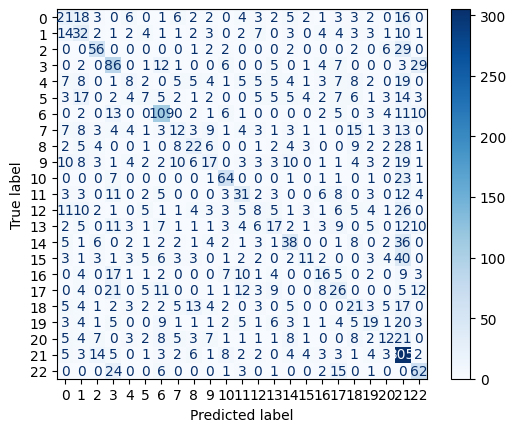

RandomForest with Sharpness Features:
Accuracy: 0.1583
Precision: 0.1729
Recall: 0.1583
F1-score: 0.1544
Confusion Matrix:
[[  8   8   1   1   6   3   3   3   5   6   0   0   3   2   4   1   2   2
    3   1   2  36   0]
 [  8  13   1   7   5   1   0   6   4   5   1   1   2   0   2   0   0   1
    4   1   2  36   0]
 [  3   0  17   4   0   0   1   0   2   4   1   2   0   1   5   0   0   1
    2   0   0  57   0]
 [  2   1   4  65   1   3   7   1   3   0   1   2   0   7   0   1   3   5
    0   1   1  27  22]
 [  5   5   0   3   5   1   5   6   7   8   1   1   1   1   4   0   1   3
    8   1   1  32   1]
 [  4   5   0  11   6   5  12   4   4   4   1   1   1   1   2   2   1   7
    2   2   1  17   5]
 [  1   1   3  16   0   3  80   2   3   1   1   3   3   4   0   1   2  13
    4   6   0  15   7]
 [ 11   4   1   2   2   3   5   8   6   5   4   0   4   1   4   4   0   0
    9   2   0  25   0]
 [  5   2   3   2   6   1   4   6  11  11   0   0   2   0   4   1   2   5
    5   0   2  28   0]
 [  

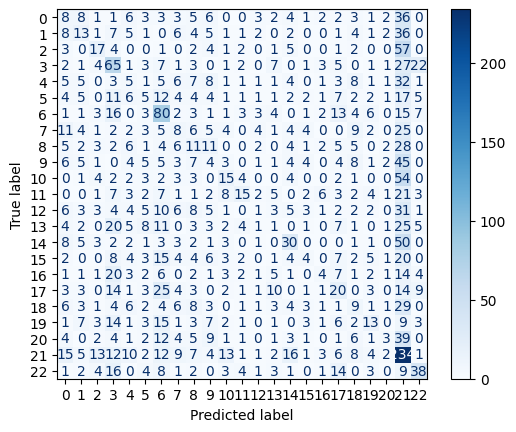

RandomForest with HOG Features:
Accuracy: 0.1077
Precision: 0.2331
Recall: 0.1077
F1-score: 0.1019
Confusion Matrix:
[[  2   1   4   2   0   0   1   1   0   5   0   0   0   0   0   0   0   0
    1   0   1  82   0]
 [  1   3   5   0   0   0   0   1   1   4   0   0   1   0   1   0   0   0
    0   0   5  78   0]
 [  0   1   7   1   0   0   1   1   0   3   0   0   1   0   0   0   0   0
    0   0   2  83   0]
 [  0   0   1  23   0   0   6   0   0   0   5   1   0   0   3   0   0   2
    0   0   0 105  11]
 [  0   2   1   2   1   0   0   1   0   0   0   0   1   0   1   0   0   2
    1   0   6  81   1]
 [  0   3   1   4   0   0   5   0   1   1   3   1   0   0   1   0   0   0
    0   0   0  76   2]
 [  0   0   0  10   0   0  29   0   0   1   3   2   0   0   0   0   0   1
    0   0   0 119   4]
 [  1   1   3   3   1   0   2   2   0   2   0   0   0   0   0   0   0   0
    0   0   1  84   0]
 [  3   0   5   2   1   0   1   0   0   1   0   0   0   1   3   0   0   0
    0   1   1  81   0]
 [  1   0 

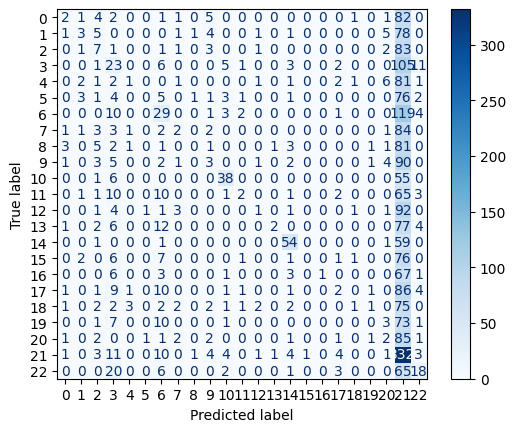

RandomForest with LBP Features:
Accuracy: 0.1848
Precision: 0.2013
Recall: 0.1848
F1-score: 0.1818
Confusion Matrix:
[[  5   9   3   1   4   4   3   4   3   5   3   2   4   0   1   1   2   1
    5   1   0  38   1]
 [ 11  19   5   1   3   4   2   7   3   2   2   0   5   3   2   1   2   0
    5   0   0  22   1]
 [  4   1  27   0   1   2   0   2   6   0   3   0   1   0   5   1   0   0
    4   0   1  42   0]
 [  0   3   0  37   2   0  16   1   0   1  20   7   0   2   1   1   9   9
    2   0   2  30  14]
 [  5   4   4   0   7   2   2  12   6   5   6   2   3   2   1   2   0   3
    4   1   0  29   0]
 [  5   8   0   2   5   2   9   3   6   4   0   6   0   1   0   2   0   5
    6   2   0  29   3]
 [  0   1   1   8   1   2  87   1   0   1   0   5   0   3   1   2   2   5
    0   5   3  29  12]
 [  8   5   1   0   2   5   5  18   2   2   0   0   4   0   4   0   1   1
    2   0   3  37   0]
 [  3   5   7   0   4   0   1   5  25   5   1   1   4   0   1   4   0   0
   12   2   0  20   0]
 [  6   8 

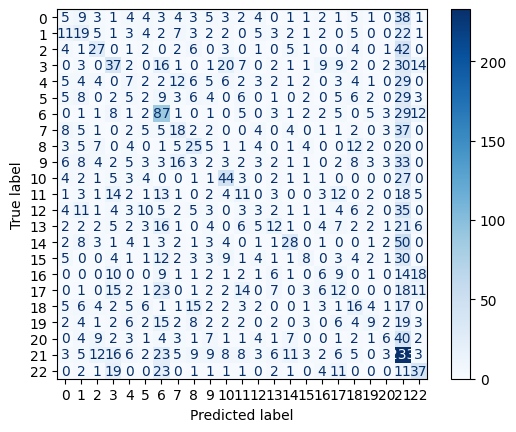

RandomForest with Combined Features:
Accuracy: 0.0987
Precision: 0.1715
Recall: 0.0987
F1-score: 0.0927
Confusion Matrix:
[[  1   3   1   3   1   0   0   2   0   2   2   0   1   0   1   0   0   0
    1   0   2  80   0]
 [  5   2   4   1   3   0   2   3   0   3   0   0   2   0   0   0   0   0
    0   0   4  71   0]
 [  0   1   2   0   0   0   0   1   1   2   0   0   0   0   0   0   0   1
    0   0   2  90   0]
 [  0   0   0  22   0   2   9   0   0   0   6   2   0   0   2   0   0   2
    0   0   0 105   7]
 [  3   2   5   1   2   0   1   2   0   2   1   0   2   1   0   0   0   0
    1   0   0  77   0]
 [  0   3   1   2   1   2   2   0   0   0   0   0   0   1   1   0   0   2
    0   1   0  81   1]
 [  1   0   1  19   0   0  24   0   1   1   2   0   0   2   0   1   1   1
    0   1   1 110   3]
 [  0   0   3   0   0   0   1   0   1   3   1   0   0   0   0   0   0   0
    0   0   1  90   0]
 [  2   1   2   1   0   0   0   1   0   3   0   0   1   0   0   0   0   0
    0   0   4  85   0]
 [  0

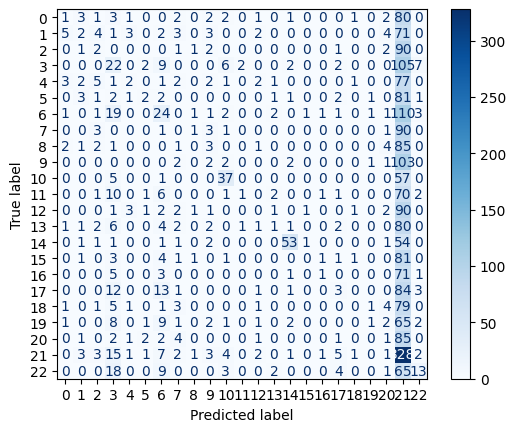

In [55]:
rf_hist_metrics = compute_metrics(y_hist_test, rf_y_hist_pred)
print("RandomForest with Histogram Features:")
print_metrics(*rf_hist_metrics)

rf_sharp_metrics = compute_metrics(y_sharp_test, rf_y_sharp_pred)
print("RandomForest with Sharpness Features:")
print_metrics(*rf_sharp_metrics)

rf_hog_metrics = compute_metrics(y_hog_test, rf_y_hog_pred)
print("RandomForest with HOG Features:")
print_metrics(*rf_hog_metrics)

rf_lbp_metrics = compute_metrics(y_lbp_test, rf_y_lbp_pred)
print("RandomForest with LBP Features:")
print_metrics(*rf_lbp_metrics)

rf_combined_metrics = compute_metrics(y_combined_test, rf_y_combined_pred)
print("RandomForest with Combined Features:")
print_metrics(*rf_combined_metrics)

# Lưu lại mô hình sau khi huấn luyện thử

In [ ]:
import joblib
import json
import pandas as pd

os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)

def _save_if_exists(obj_name, filename, model_type):
    """Lưu mô hình vào thư mục riêng theo loại mô hình"""
    obj = globals().get(obj_name, None)
    if obj is None:
        print(f"Skipping {obj_name} (not found).")
        return False
    
    # Tạo thư mục cho từng loại mô hình
    model_dir = os.path.join(MODEL_OUTPUT_DIR, model_type)
    os.makedirs(model_dir, exist_ok=True)
    
    path = os.path.join(model_dir, filename)
    joblib.dump(obj, path)
    print(f"Saved {obj_name} -> {path}")
    return True

# Định nghĩa danh sách mô hình với loại tương ứng
models_to_save = {
    # SVC models
    "svc_hist": ("svc_hist.joblib", "SVC"),
    "svc_sharp": ("svc_sharp.joblib", "SVC"),
    "svc_hog": ("svc_hog.joblib", "SVC"),
    "svc_lbp": ("svc_lbp.joblib", "SVC"),
    "svc_combined": ("svc_combined.joblib", "SVC"),
    
    # Logistic Regression models
    "logreg_hist": ("logreg_hist.joblib", "LogisticRegression"),
    "logreg_sharp": ("logreg_sharp.joblib", "LogisticRegression"),
    "logreg_hog": ("logreg_hog.joblib", "LogisticRegression"),
    "logreg_lbp": ("logreg_lbp.joblib", "LogisticRegression"),
    "logreg_combined": ("logreg_combined.joblib", "LogisticRegression"),
    
    # KNN models
    "knn_hist": ("knn_hist.joblib", "KNN"),
    "knn_sharp": ("knn_sharp.joblib", "KNN"),
    "knn_hog": ("knn_hog.joblib", "KNN"),
    "knn_lbp": ("knn_lbp.joblib", "KNN"),
    "knn_combined": ("knn_combined.joblib", "KNN"),
    
    # XGBoost models
    "xgb_hist": ("xgb_hist.joblib", "XGBoost"),
    "xgb_sharp": ("xgb_sharp.joblib", "XGBoost"),
    "xgb_hog": ("xgb_hog.joblib", "XGBoost"),
    "xgb_lbp": ("xgb_lbp.joblib", "XGBoost"),
    "xgb_combined": ("xgb_combined.joblib", "XGBoost"),

    # RandomForest models (mới)
    "rf_hist": ("rf_hist.joblib", "RandomForest"),
    "rf_sharp": ("rf_sharp.joblib", "RandomForest"),
    "rf_hog": ("rf_hog.joblib", "RandomForest"),
    "rf_lbp": ("rf_lbp.joblib", "RandomForest"),
    "rf_combined": ("rf_combined.joblib", "RandomForest"),
}

print("Saving models to organized directories ...")
for var_name, (fname, model_type) in models_to_save.items():
    _save_if_exists(var_name, fname, model_type)

# Lưu tổng hợp metrics vào CSV
metrics_rows = []
def _append_metric_row(model, feature, metric_var_name):
    metric = globals().get(metric_var_name, None)
    if metric is None:
        return
    acc, prec, rec, f1, _ = metric
    metrics_rows.append({
        "model": model,
        "feature": feature,
        "accuracy": float(acc),
        "precision": float(prec),
        "recall": float(rec),
        "f1": float(f1)
    })

# Map tên biến metrics trong notebook
_append_metric_row("SVC", "Histogram", "svc_hist_metrics")
_append_metric_row("SVC", "Sharpness", "svc_sharp_metrics")
_append_metric_row("SVC", "HOG", "svc_hog_metrics")
_append_metric_row("SVC", "LBP", "svc_lbp_metrics")
_append_metric_row("SVC", "Combined", "svc_combined_metrics")

_append_metric_row("LR", "Histogram", "lr_hist_metrics")
_append_metric_row("LR", "Sharpness", "lr_sharp_metrics")
_append_metric_row("LR", "HOG", "lr_hog_metrics")
_append_metric_row("LR", "LBP", "lr_lbp_metrics")
_append_metric_row("LR", "Combined", "lr_combined_metrics")

_append_metric_row("KNN", "Histogram", "knn_hist_metrics")
_append_metric_row("KNN", "Sharpness", "knn_sharp_metrics")
_append_metric_row("KNN", "HOG", "knn_hog_metrics")
_append_metric_row("KNN", "LBP", "knn_lbp_metrics")
_append_metric_row("KNN", "Combined", "knn_combined_metrics")

_append_metric_row("XGB", "Histogram", "xgb_hist_metrics")
_append_metric_row("XGB", "Sharpness", "xgb_sharp_metrics")
_append_metric_row("XGB", "HOG", "xgb_hog_metrics")
_append_metric_row("XGB", "LBP", "xgb_lbp_metrics")
_append_metric_row("XGB", "Combined", "xgb_combined_metrics")

if metrics_rows:
    df_metrics = pd.DataFrame(metrics_rows)
    metrics_csv = os.path.join(MODEL_OUTPUT_DIR, "metrics_summary.csv")
    df_metrics.to_csv(metrics_csv, index=False)
    print(f"Saved metrics summary -> {metrics_csv}")
    display(df_metrics.round(4))
else:
    print("No metric variables found to save summary.")

# Tạo manifest của toàn bộ cấu trúc thư mục và file
def create_manifest(base_dir):
    """Tạo manifest của cấu trúc thư mục"""
    manifest = {}
    for root, dirs, files in os.walk(base_dir):
        rel_path = os.path.relpath(root, base_dir)
        if rel_path == ".":
            rel_path = "root"
        manifest[rel_path] = files
    return manifest

manifest = create_manifest(MODEL_OUTPUT_DIR)
manifest_path = os.path.join(MODEL_OUTPUT_DIR, "manifest.json")
with open(manifest_path, "w", encoding="utf-8") as f:
    json.dump(manifest, f, indent=2)
print(f"Saved manifest -> {manifest_path}")

# Helper function để nạp mô hình
def load_model(model_type, model_name):
    """
    Nạp mô hình từ thư mục
    
    Parameters:
    - model_type: "SVC", "KNN", "LogisticRegression", "XGBoost"
    - model_name: "hist", "sharp", "hog", "lbp", "combined"
    
    Example:
    clf = load_model("XGBoost", "combined")
    """
    filename = f"{model_type.lower()}_{model_name}.joblib" if model_type != "XGBoost" else f"xgb_{model_name}.joblib"
    path = os.path.join(MODEL_OUTPUT_DIR, model_type, filename)
    if not os.path.exists(path):
        raise FileNotFoundError(f"Model not found: {path}")
    return joblib.load(path)

print("\n✓ All models saved successfully!")

## Trực quan hóa kết quả

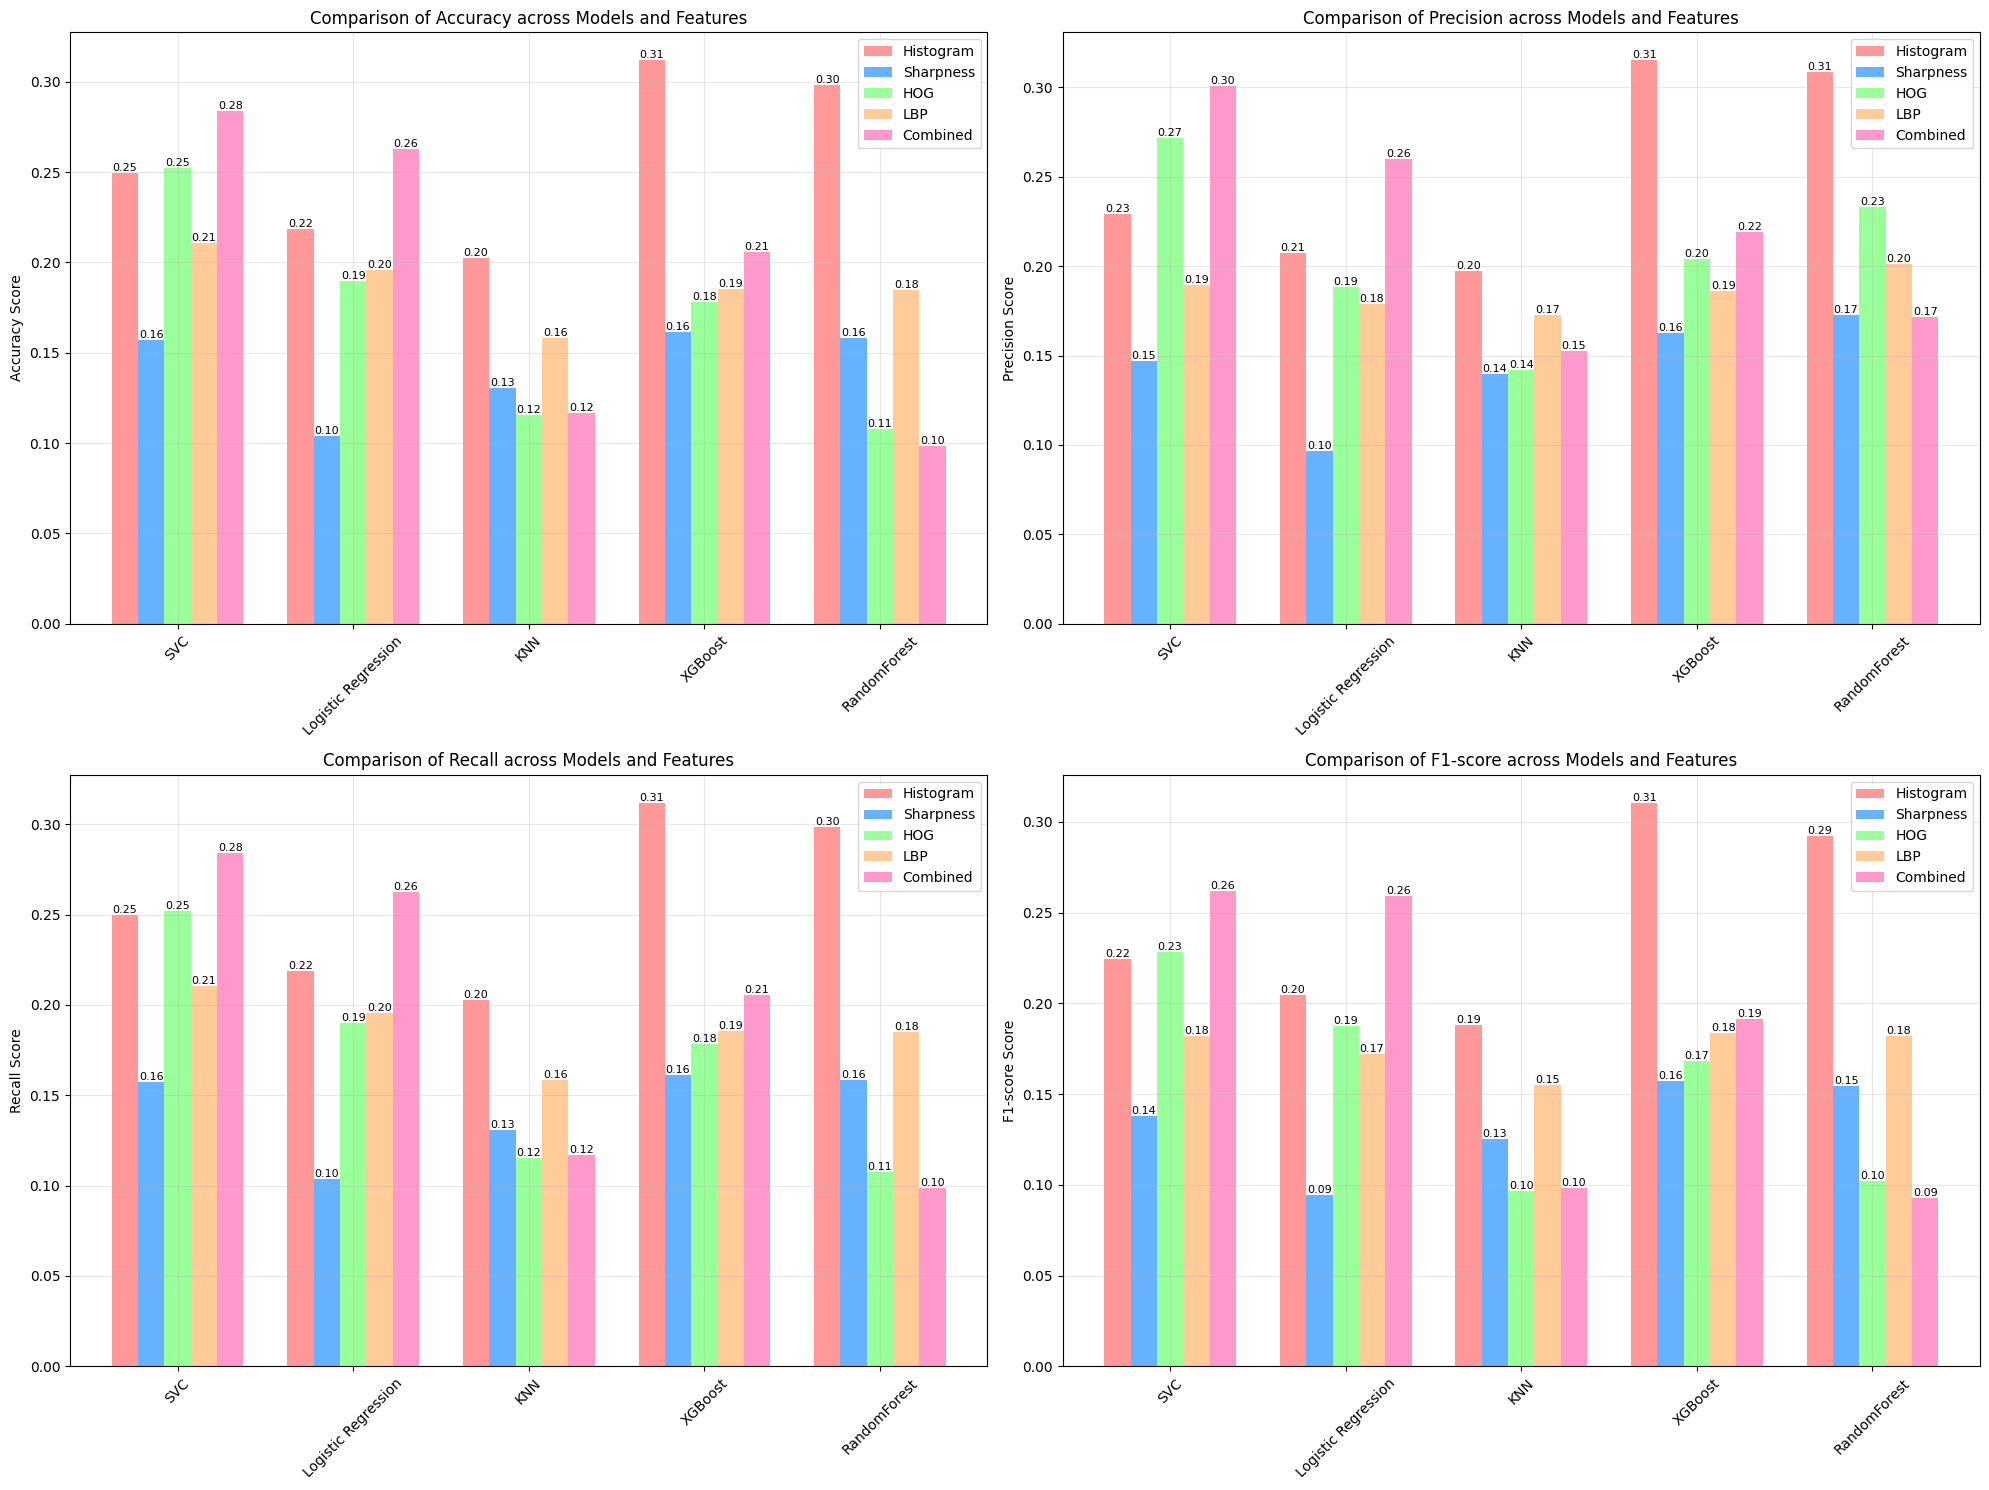

In [57]:
features = ['Histogram', 'Sharpness', 'HOG', 'LBP', 'Combined']
feature_keys = {'Histogram': 'hist', 
                'Sharpness': 'sharp', 
                'HOG': 'hog', 
                'LBP': 'lbp', 
                'Combined': 'combined'}

model_prefixes = {
    'SVC': 'svc',
    'Logistic Regression': 'lr',
    'KNN': 'knn',
    'XGBoost': 'xgb',
    'RandomForest': 'rf'
}

models_results = {}
for model_name, prefix in model_prefixes.items():
    # kiểm tra nếu ít nhất 1 biến metrics tồn tại thì thêm model
    if globals().get(f"{prefix}_hist_metrics") is None and globals().get(f"{prefix}_combined_metrics") is None:
        continue
    models_results[model_name] = {}
    for feat_name, feat_key in feature_keys.items():
        var_name = f"{prefix}_{feat_key}_metrics"
        metrics = globals().get(var_name, None)
        if metrics is None:
            # nếu không có metrics thì đặt giá trị None hoặc 0 để vẫn hiển thị cấu trúc
            models_results[model_name][feat_name] = (0.0, 0.0, 0.0, 0.0)
        else:
            models_results[model_name][feat_name] = metrics[0:4]

if not models_results:
    print("No model metrics found to visualize.")
else:
    # Tạo biểu đồ
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-score']
    models = list(models_results.keys())

    colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FF99CC']

    plt.figure(figsize=(20, 15))

    for idx, metric in enumerate(metrics_names):
        plt.subplot(2, 2, idx+1)

        x = np.arange(len(models))
        width = 0.15

        for i, feature in enumerate(features):
            values = [models_results[m][feature][idx] for m in models]
            bars = plt.bar(x + i*width - width*2, values, width, label=feature, color=colors[i])
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height,
                         f'{height:.2f}', ha='center', va='bottom', fontsize=8)

        plt.ylabel(f'{metric} Score')
        plt.title(f'Comparison of {metric} across Models and Features')
        plt.xticks(x, models, rotation=45)
        plt.grid(True, alpha=0.3)
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Tạo bảng tổng hợp kết quả và hiển thị
    data = []
    for model in models:
        for feature in features:
            metrics = models_results[model][feature]
            data.append([model, feature] + list(metrics))

    #columns = ['Model', 'Feature'] + metrics_names
    #df_summary = pd.DataFrame(data, columns=columns)
    #display(df_summary.round(4))

# Tinh chỉnh các mô hình

## Thiết lập lớp để thực hiện tinh chỉnh

In [60]:
class ModelTuner:
    """
    Grid-search tuner wrapper.

    Usage:
      tuner = ModelTuner({
          'svc_hist': (SVC(...), {'C': [0.1,1], 'kernel':['rbf']}),
          'rf_combined': (RandomForestClassifier(...), {'n_estimators':[100,200]})
      }, cv=3, scoring='f1_weighted')
      best, params = tuner.tune('svc_hist', X_hist_train, y_hist_train)
      tuner.tune_all(X_dict, y_dict, sample_weight_dict=...)
      tuner.save_summary()
    """
    def __init__(self, models_param_grid, cv=5, scoring='f1_macro', n_jobs=-1, refit=True):
        self.models_param_grid = models_param_grid
        self.cv = cv
        self.scoring = scoring
        self.n_jobs = n_jobs
        self.refit = refit
        self.results = {}   # store GridSearchCV objects
        os.makedirs(os.path.join(MODEL_OUTPUT_DIR, "tuning"), exist_ok=True)

    def tune(self, key, X, y, sample_weight=None, verbose=1):
        if key not in self.models_param_grid:
            raise KeyError(f"Model key not found: {key}")
        estimator, param_grid = self.models_param_grid[key]
        gs = GridSearchCV(estimator, param_grid, cv=self.cv, scoring=self.scoring,
                          n_jobs=self.n_jobs, refit=self.refit, verbose=verbose)
        if sample_weight is not None:
            gs.fit(X, y, **{'sample_weight': sample_weight})
        else:
            gs.fit(X, y)
        self.results[key] = gs
        # save best estimator
        best_path = os.path.join(MODEL_OUTPUT_DIR, "tuning", f"{key}_best.joblib")
        joblib.dump(gs.best_estimator_, best_path)
        return gs.best_estimator_, gs.best_params_, gs.best_score_

    def tune_all(self, X_dict, y_dict, sample_weight_dict=None, verbose=0):
        """
        X_dict, y_dict: maps keys used in models_param_grid to (X, y) pairs or separate dicts.
        sample_weight_dict: optional dict mapping key -> sample_weight array
        """
        for key in list(self.models_param_grid.keys()):
            if key not in X_dict or key not in y_dict:
                continue
            sw = None
            if sample_weight_dict is not None:
                sw = sample_weight_dict.get(key, None)
            self.tune(key, X_dict[key], y_dict[key], sample_weight=sw, verbose=verbose)

    def get_best(self, key):
        gs = self.results.get(key)
        if gs is None:
            return None
        return gs.best_estimator_, gs.best_params_, gs.best_score_

    def summary_df(self):
        rows = []
        for key, gs in self.results.items():
            rows.append({
                "key": key,
                "best_score": float(gs.best_score_),
                "best_params": gs.best_params_
            })
        import pandas as pd
        return pd.DataFrame(rows)

    def save_summary(self, filename="tuning_summary.csv"):
        df = self.summary_df()
        out = os.path.join(MODEL_OUTPUT_DIR, "tuning", filename)
        df.to_csv(out, index=False)
        return out

## Thiết lập tham số dùng để tinh chỉnh cho các mô hình

In [61]:
models_param_grid = {
    # SVC
    "svc_hist": (
        SVC(random_state=42, class_weight="balanced"),
        {"C": [0.1, 1, 10], "kernel": ["rbf", "linear"], "gamma": ["scale", "auto"]}
    ),
    "svc_sharp": (
        SVC(random_state=42, class_weight="balanced"),
        {"C": [0.1, 1, 10], "kernel": ["rbf", "linear"], "gamma": ["scale", "auto"]}
    ),
    "svc_hog": (
        SVC(random_state=42, class_weight="balanced"),
        {"C": [0.1, 1, 10], "kernel": ["rbf", "linear"], "gamma": ["scale", "auto"]}
    ),
    "svc_lbp": (
        SVC(random_state=42, class_weight="balanced"),
        {"C": [0.1, 1, 10], "kernel": ["rbf", "linear"], "gamma": ["scale", "auto"]}
    ),
    "svc_combined": (
        SVC(random_state=42, class_weight="balanced"),
        {"C": [0.1, 1, 10], "kernel": ["rbf", "linear"], "gamma": ["scale", "auto"]}
    ),

    # Logistic Regression
    "lr_hist": (
        LogisticRegression(max_iter=2000, random_state=42, class_weight="balanced"),
        {"C": [0.01, 0.1, 1, 10], "solver": ["lbfgs", "saga"], "penalty": ["l2"]}
    ),
    "lr_sharp": (
        LogisticRegression(max_iter=2000, random_state=42, class_weight="balanced"),
        {"C": [0.01, 0.1, 1, 10], "solver": ["lbfgs", "saga"], "penalty": ["l2"]}
    ),
    "lr_hog": (
        LogisticRegression(max_iter=2000, random_state=42, class_weight="balanced"),
        {"C": [0.01, 0.1, 1, 10], "solver": ["lbfgs", "saga"], "penalty": ["l2"]}
    ),
    "lr_lbp": (
        LogisticRegression(max_iter=2000, random_state=42, class_weight="balanced"),
        {"C": [0.01, 0.1, 1, 10], "solver": ["lbfgs", "saga"], "penalty": ["l2"]}
    ),
    "lr_combined": (
        LogisticRegression(max_iter=2000, random_state=42, class_weight="balanced"),
        {"C": [0.01, 0.1, 1, 10], "solver": ["lbfgs", "saga"], "penalty": ["l2"]}
    ),

    # KNN
    "knn_hist": (
        KNeighborsClassifier(),
        {"n_neighbors": [3, 5, 11, 24], "weights": ["uniform", "distance"], "metric": ["minkowski", "euclidean"]}
    ),
    "knn_sharp": (
        KNeighborsClassifier(),
        {"n_neighbors": [3, 5, 11, 24], "weights": ["uniform", "distance"], "metric": ["minkowski", "euclidean"]}
    ),
    "knn_hog": (
        KNeighborsClassifier(),
        {"n_neighbors": [3, 5, 11, 24], "weights": ["uniform", "distance"], "metric": ["minkowski", "euclidean"]}
    ),
    "knn_lbp": (
        KNeighborsClassifier(),
        {"n_neighbors": [3, 5, 11, 24], "weights": ["uniform", "distance"], "metric": ["minkowski", "euclidean"]}
    ),
    "knn_combined": (
        KNeighborsClassifier(),
        {"n_neighbors": [3, 5, 11, 24], "weights": ["uniform", "distance"], "metric": ["minkowski", "euclidean"]}
    ),

    # XGBoost
    "xgb_hist": (
        XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42, n_jobs=-1),
        {"n_estimators": [100, 200], "max_depth": [3, 6], "learning_rate": [0.01, 0.1], "subsample": [0.8, 1.0]}
    ),
    "xgb_sharp": (
        XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42, n_jobs=-1),
        {"n_estimators": [100, 200], "max_depth": [3, 6], "learning_rate": [0.01, 0.1], "subsample": [0.8, 1.0]}
    ),
    "xgb_hog": (
        XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42, n_jobs=-1),
        {"n_estimators": [100, 200], "max_depth": [3, 6], "learning_rate": [0.01, 0.1], "subsample": [0.8, 1.0]}
    ),
    "xgb_lbp": (
        XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42, n_jobs=-1),
        {"n_estimators": [100, 200], "max_depth": [3, 6], "learning_rate": [0.01, 0.1], "subsample": [0.8, 1.0]}
    ),
    "xgb_combined": (
        XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42, n_jobs=-1),
        {"n_estimators": [100, 200], "max_depth": [3, 6], "learning_rate": [0.01, 0.1], "subsample": [0.8, 1.0]}
    ),

    # RandomForest
    "rf_hist": (
        RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced"),
        {"n_estimators": [100, 200, 500], "max_depth": [None, 10, 30], "min_samples_split": [2, 5]}
    ),
    "rf_sharp": (
        RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced"),
        {"n_estimators": [100, 200, 500], "max_depth": [None, 10, 30], "min_samples_split": [2, 5]}
    ),
    "rf_hog": (
        RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced"),
        {"n_estimators": [100, 200, 500], "max_depth": [None, 10, 30], "min_samples_split": [2, 5]}
    ),
    "rf_lbp": (
        RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced"),
        {"n_estimators": [100, 200, 500], "max_depth": [None, 10, 30], "min_samples_split": [2, 5]}
    ),
    "rf_combined": (
        RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced"),
        {"n_estimators": [100, 200, 500], "max_depth": [None, 10, 30], "min_samples_split": [2, 5]}
    ),
}

# Tạo dict X/y theo key dùng cho ModelTuner.tune / tune_all
X_dict = {
    "svc_hist": X_hist_train, "lr_hist": X_hist_train, "knn_hist": X_hist_train, "xgb_hist": X_hist_train, "rf_hist": X_hist_train,
    "svc_sharp": X_sharp_train, "lr_sharp": X_sharp_train, "knn_sharp": X_sharp_train, "xgb_sharp": X_sharp_train, "rf_sharp": X_sharp_train,
    "svc_hog": X_hog_train, "lr_hog": X_hog_train, "knn_hog": X_hog_train, "xgb_hog": X_hog_train, "rf_hog": X_hog_train,
    "svc_lbp": X_lbp_train, "lr_lbp": X_lbp_train, "knn_lbp": X_lbp_train, "xgb_lbp": X_lbp_train, "rf_lbp": X_lbp_train,
    "svc_combined": X_combined_train, "lr_combined": X_combined_train, "knn_combined": X_combined_train, "xgb_combined": X_combined_train, "rf_combined": X_combined_train,
}

y_dict = {
    "svc_hist": y_hist_train, "lr_hist": y_hist_train, "knn_hist": y_hist_train, "xgb_hist": y_hist_train, "rf_hist": y_hist_train,
    "svc_sharp": y_sharp_train, "lr_sharp": y_sharp_train, "knn_sharp": y_sharp_train, "xgb_sharp": y_sharp_train, "rf_sharp": y_sharp_train,
    "svc_hog": y_hog_train, "lr_hog": y_hog_train, "knn_hog": y_hog_train, "xgb_hog": y_hog_train, "rf_hog": y_hog_train,
    "svc_lbp": y_lbp_train, "lr_lbp": y_lbp_train, "knn_lbp": y_lbp_train, "xgb_lbp": y_lbp_train, "rf_lbp": y_lbp_train,
    "svc_combined": y_combined_train, "lr_combined": y_combined_train, "knn_combined": y_combined_train, "xgb_combined": y_combined_train, "rf_combined": y_combined_train,
}

# Nếu đã tính sample_weights (ví dụ cho XGBoost) thì map vào dict
sample_weight_dict = {}
try:
    sample_weight_dict = {
        "xgb_hist": sample_weights_hist,
        "xgb_sharp": sample_weights_sharp,
        "xgb_hog": sample_weights_hog,
        "xgb_lbp": sample_weights_lbp,
        "xgb_combined": sample_weights_combined,
    }
except NameError:
    sample_weight_dict = {}

# Tạo instance của ModelTuner (khuyến nghị scoring='f1_macro' cho multi-class imbalance)
tuner = ModelTuner(models_param_grid, cv=5, scoring="f1_macro", n_jobs=-1, refit=True)

# Gợi ý sử dụng (commented out để không chạy tự động)
tuner.tune_all(X_dict, y_dict, sample_weight_dict=sample_weight_dict, verbose=2)
tuner.save_summary()

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


KeyboardInterrupt: 